Data Head:
                  passengers
observation_date            
2000-01-01          41540000
2000-02-01          43714000
2000-03-01          52977000
2000-04-01          50344000
2000-05-01          52309000

Data Tail (Most Recent):
                  passengers
observation_date            
2025-03-01          72243000
2025-04-01          69614000
2025-05-01          74251000
2025-06-01          76305000
2025-07-01          78855000


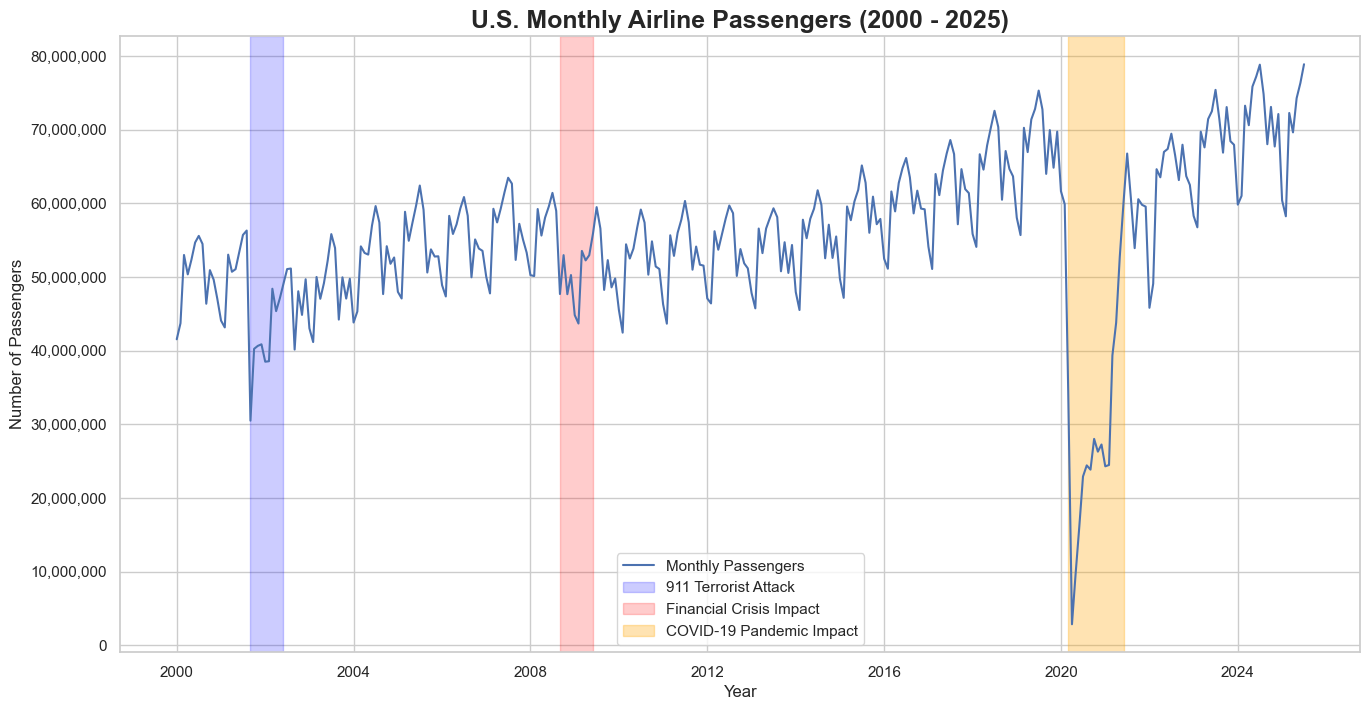

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 设置绘图风格
sns.set_theme(style="whitegrid")

# --- 数据加载 ---
data = pd.read_csv('ENPLANED.csv', index_col='observation_date', parse_dates=True)

# --- 数据预处理 ---
data.rename(columns={'ENPLANED': 'passengers'}, inplace=True)                                                                 
# FRED数据单位是千人 (Thousands of Persons)，我们将其转换为实际人数
data['passengers'] = data['passengers'] * 1000

# 打印数据信息
print("Data Head:")
print(data.head())
print("\nData Tail (Most Recent):")
print(data.tail())

# --- 数据可视化 ---
plt.figure(figsize=(16, 8))
plt.plot(data.index, data['passengers'], label='Monthly Passengers')

# --- 突出显示重大事件---
plt.axvspan('2001-09-01', '2002-06-01', color='blue', alpha=0.2, label='911 Terrorist Attack')
plt.axvspan('2008-09-01', '2009-06-01', color='red', alpha=0.2, label='Financial Crisis Impact')
plt.axvspan('2020-03-01', '2021-06-01', color='orange', alpha=0.3, label='COVID-19 Pandemic Impact')

# 添加标题和标签
plt.title('U.S. Monthly Airline Passengers (2000 - 2025)', fontsize=18, weight='bold')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Passengers', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().get_yaxis().set_major_formatter(
    plt.FuncFormatter(lambda x, p: format(int(x), ','))
)
plt.show()

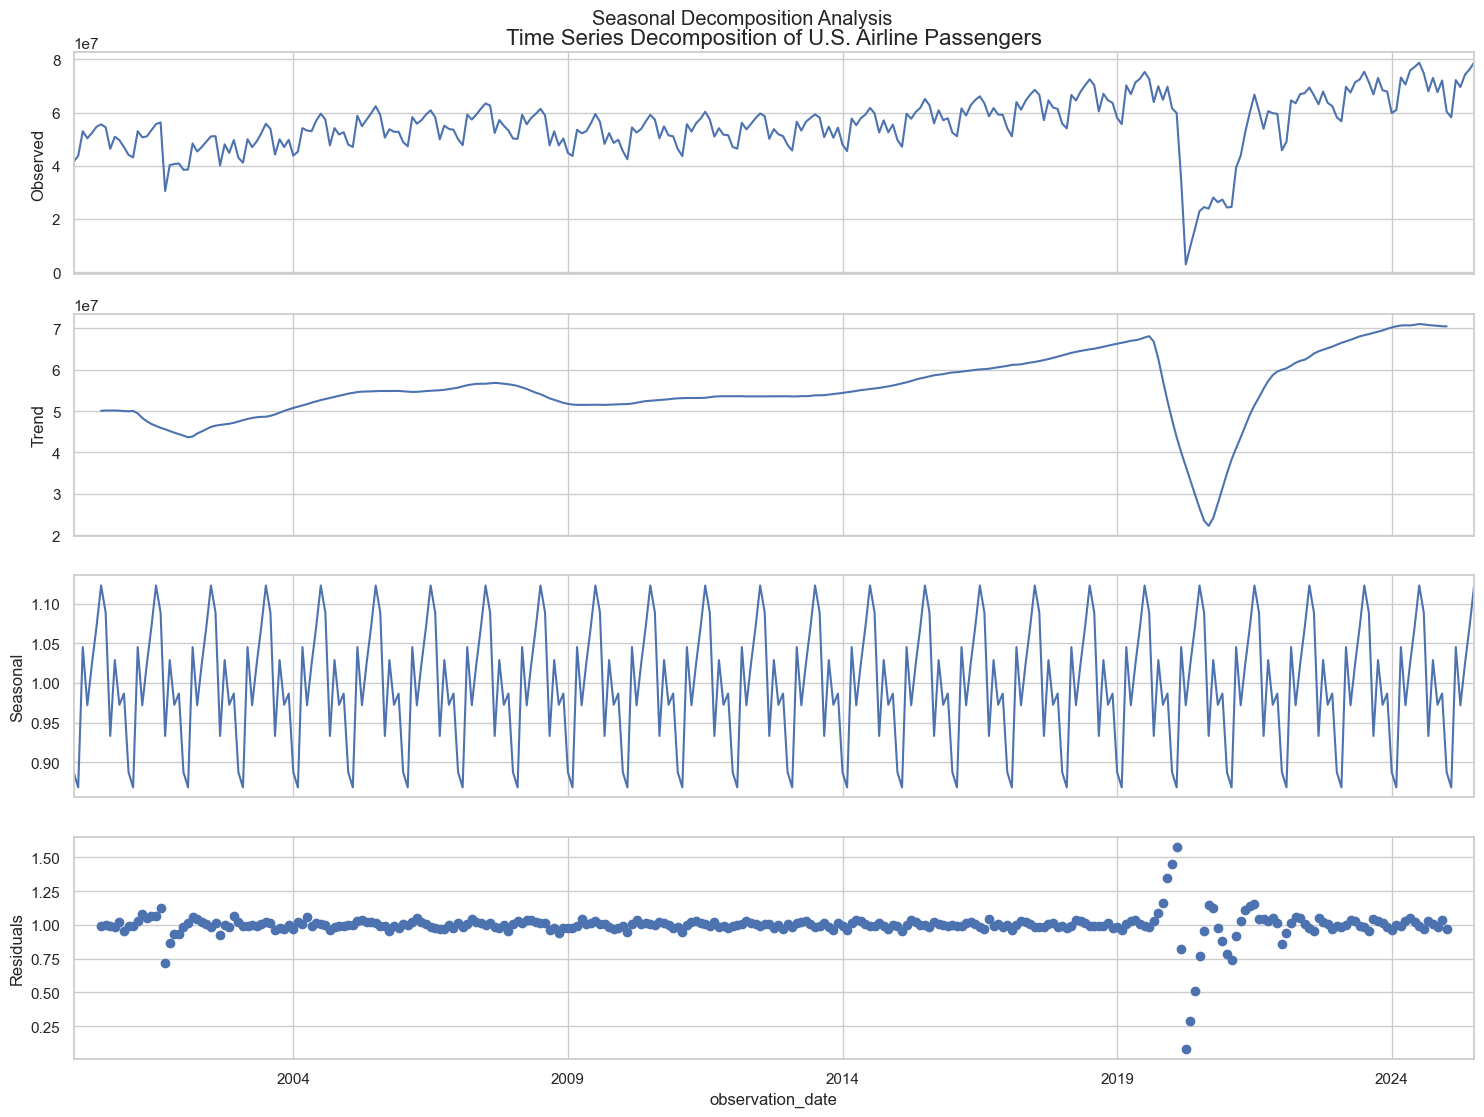

In [2]:
from statsmodels.tsa.seasonal import seasonal_decompose

# --- 时间序列分解 ---
# 使用乘法模型 (multiplicative)
# period=12 表示季节性周期为12个月
decomposition = seasonal_decompose(data['passengers'], model='multiplicative', period=12)

# --- 结果可视化 ---
# 创建一个大图来容纳四个子图
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 12), sharex=True)

# 1. 原始数据
decomposition.observed.plot(ax=ax1)
ax1.set_ylabel('Observed')
ax1.set_title('Time Series Decomposition of U.S. Airline Passengers', fontsize=16)

# 2. 趋势 component
decomposition.trend.plot(ax=ax2)
ax2.set_ylabel('Trend')

# 3. 季节性 component
decomposition.seasonal.plot(ax=ax3)
ax3.set_ylabel('Seasonal')

# 4. 残差 component
decomposition.resid.plot(ax=ax4, marker='o', linestyle='none')
ax4.set_ylabel('Residuals')

plt.suptitle('Seasonal Decomposition Analysis', y=0.93)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


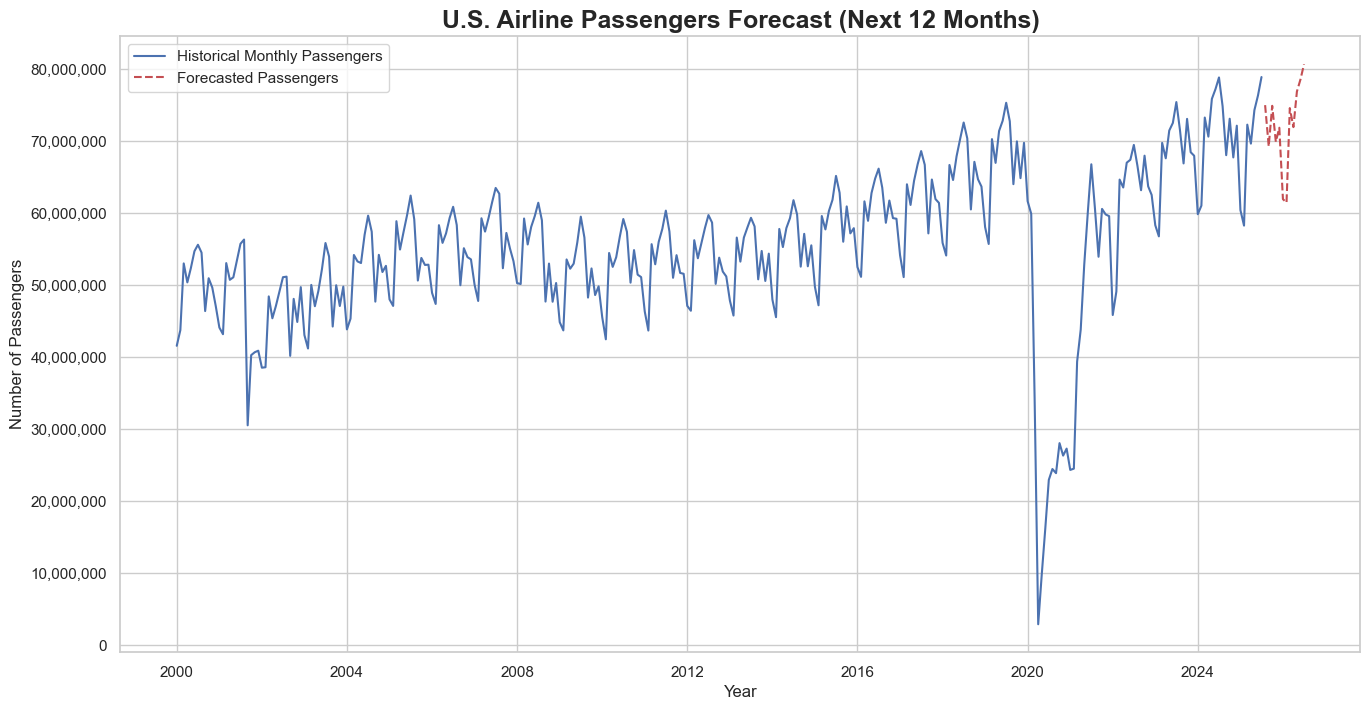

In [6]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.tseries.offsets import DateOffset
import warnings
from statsmodels.tools.sm_exceptions import ValueWarning
warnings.filterwarnings('ignore', category=ValueWarning)
# --- 训练SARIMA模型 ---
# 我们选择一个常用的SARIMA模型参数(p,d,q)(P,D,Q,s)
# (1,1,1)处理非季节性部分, (1,1,0,12)处理季节性部分
model = SARIMAX(data['passengers'],
                order=(1, 1, 1),
                seasonal_order=(1, 1, 0, 12),
                enforce_stationarity=False,
                enforce_invertibility=False)

# 拟合模型
results = model.fit()

# --- 进行未来12个月的预测 ---
# 计算预测的起止日期
future_start_date = data.index[-1] + DateOffset(months=1)
future_end_date = data.index[-1] + DateOffset(months=12)
# 生成预测
predictions = results.get_prediction(start=future_start_date, end=future_end_date, dynamic=True)
predicted_mean = predictions.predicted_mean

# --- 结果可视化 ---
plt.figure(figsize=(16, 8))

# 绘制历史数据
plt.plot(data.index, data['passengers'], label='Historical Monthly Passengers')
# 绘制预测数据
plt.plot(predicted_mean.index, predicted_mean, color='r', linestyle='--', label='Forecasted Passengers')

# 添加标题和标签
plt.title('U.S. Airline Passengers Forecast (Next 12 Months)', fontsize=18, weight='bold')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Passengers', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().get_yaxis().set_major_formatter(
    plt.FuncFormatter(lambda x, p: format(int(x), ','))
)
plt.show()
